<h1>Using R with Amazon SageMaker</h1>

This sample Notebook describes how to call MARS library directly within this shell.

In [1]:
install.packages(c('mda', 'Metrics'), repos='http://cran.us.r-project.org')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [2]:
# Bring in library that contains multivariate adaptive regression splines (MARS)
library(mda)
library(Metrics)
library(readr)

Loading required package: class
Loaded mda 0.4-10



In [3]:
# Hyper paramers
target = 'Sepal.Length'
degree = 2
input_path = 'iris.csv'
output_path = 'output'
model_path = 'model'

In [4]:
# Create model and output directories
dir.create(output_path)
dir.create(model_path)

Warning message in dir.create(output_path):
“'output' already exists”Warning message in dir.create(model_path):
“'model' already exists”

In [5]:
# Bring in data
training_data <- read_csv(file = input_path, col_names = TRUE)
head(training_data)

Parsed with column specification:
cols(
  Sepal.Length = col_double(),
  Sepal.Width = col_double(),
  Petal.Length = col_double(),
  Petal.Width = col_double(),
  Species = col_character()
)


Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


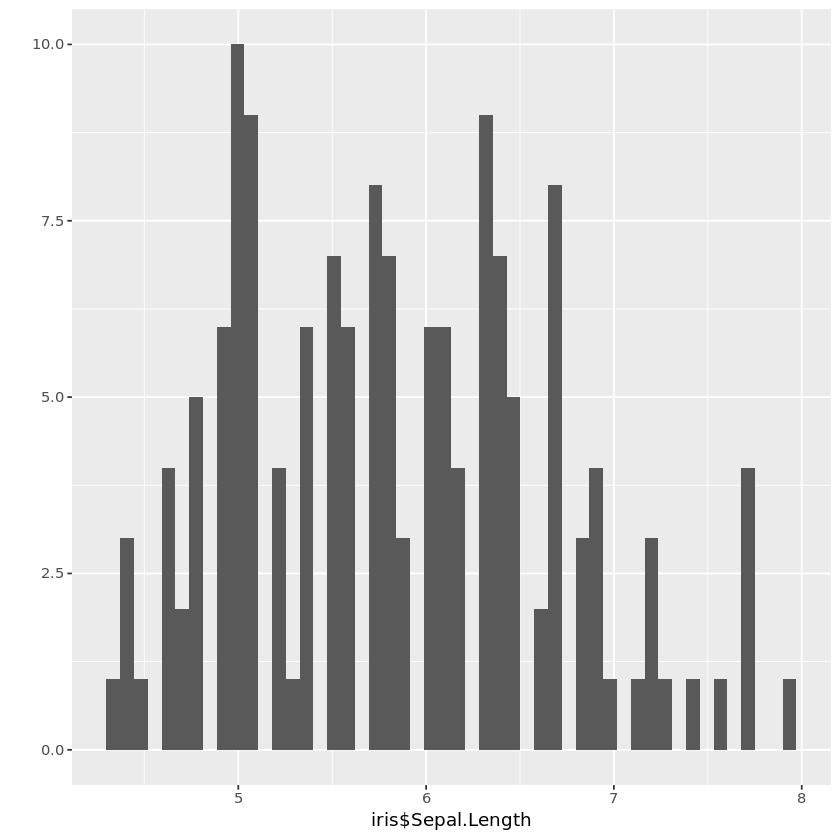

In [6]:
library(ggplot2)
qplot(iris$Sepal.Length, geom='histogram', bins=50)

In [7]:
# Convert to model matrix
training_X <- model.matrix(~., training_data[, colnames(training_data) != target])

In [8]:
# Save factor levels for scoring
factor_levels <- lapply(training_data[, sapply(training_data, is.factor), drop=FALSE],
                        function(x) {levels(x)})

In [9]:
# Run multivariate adaptive regression splines algorithm
model <- mars(x=training_X, y=training_data[, target], degree=degree)

In [10]:
# Generate outputs
mars_model <- model[!(names(model) %in% c('x', 'residuals', 'fitted.values'))]
attributes(mars_model)$class <- 'mars'
model_file <- paste(model_path, 'mars_model.RData', sep='/')
save(mars_model, factor_levels, file=model_file)
print(summary(mars_model))

               Length Class  Mode   
call             4    -none- call   
all.terms       18    -none- numeric
selected.terms   6    -none- numeric
penalty          1    -none- numeric
degree           1    -none- numeric
nk               1    -none- numeric
thresh           1    -none- numeric
gcv              1    -none- numeric
factor         126    -none- numeric
cuts           126    -none- numeric
lenb             1    -none- numeric
coefficients     6    -none- numeric


In [11]:
output_file <- paste(output_path, 'fitted_values.csv', sep='/')
write.csv(model$fitted.values, output_file, row.names=FALSE)

In [12]:
# Load back the predictions
output_data <- read_csv(file = output_file, col_names = TRUE)

Parsed with column specification:
cols(
  Sepal.Length = col_double()
)


In [13]:
iris_test <- cbind(Predicted.Length = output_data$Sepal.Length, training_data)
head(iris_test)

Predicted.Length,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.025068,5.1,3.5,1.4,0.2,setosa
4.695197,4.9,3.0,1.4,0.2,setosa
4.768124,4.7,3.2,1.3,0.2,setosa
4.820192,4.6,3.1,1.5,0.2,setosa
5.091042,5.0,3.6,1.4,0.2,setosa
5.466028,5.4,3.9,1.7,0.4,setosa


In [14]:
# Calculate the RMSE
rmse(iris_test$Sepal.Length, iris_test$Predicted.Length)

[1] 0.2981672

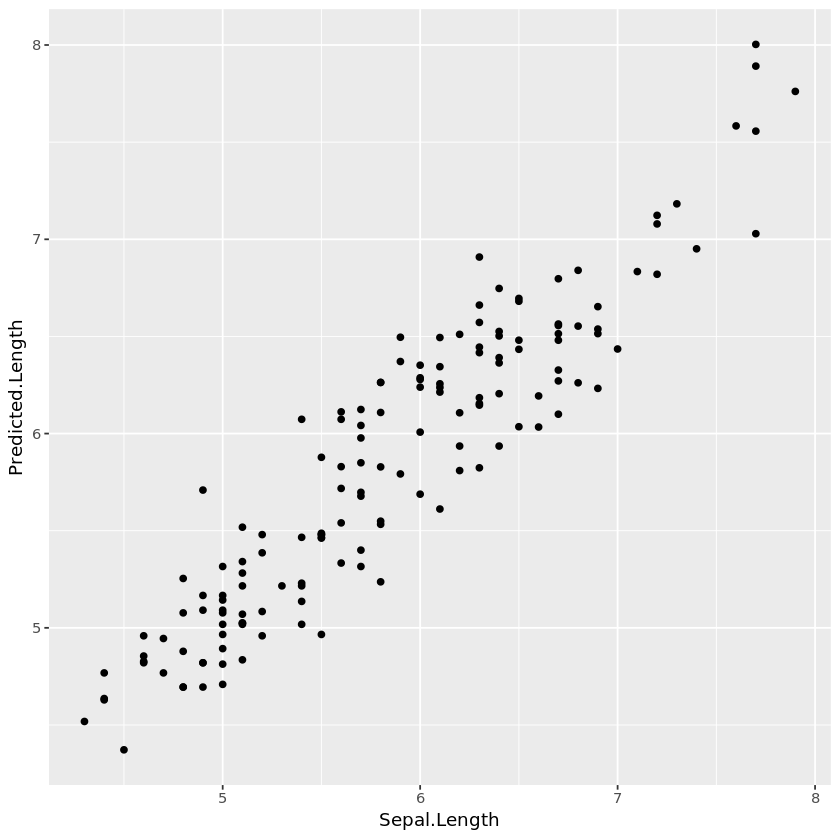

In [15]:
# Compare the predictions vs actual
ggplot(iris_test, aes(x=Sepal.Length, y=Predicted.Length)) + geom_point()